# Approximate Predictive Safety Filter - Linear System
This file contains the results of the simulation for a linear system

In [ ]:
""" Copyright (c) 2023, ETH Zurich, 
Alexandre Didier*, Robin C. Jacobs*, Jerome Sieber*, Kim P. Wabersich°, Prof. Dr. Melanie N. Zeilinger*, 
*Institute for Dynamic Systems and Control, D-MAVT
°Corporate Research of Robert Bosch GmbH
All rights reserved."""

In [1]:
import torch
import numpy as np
from casadi import *
import time
import pickle
from torch import nn
from pytope import Polytope
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import apcbf.simulation as sim
from apcbf.dynamic import LinearDiscreteDynamics
from apcbf.controller import *
from apcbf.approximator import *
from apcbf.pcbf_linear import *
from apcbf.approximate_pcbf_linear import *
from apcbf.controller import *
from apcbf.nn_model_types import *

In [2]:
# Plot settings
plt.rcParams['figure.figsize'] = [15, 10]
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 30})
plt.rc('text', usetex=True)
constraint_color = (0, 120.0/256, 148.0/256)

### Load model and system parameters

In [3]:
TORCH_MODEL_NAME = '../models/model_lup_Aplus_06_04_18_46.pt'
model_type_name = LinModelType.APLUS

In [4]:
LOG_NAME = TORCH_MODEL_NAME[13:-5]
print(LOG_NAME)

el_lup_Aplus_06_04_18_


In [5]:
model = torch.load(TORCH_MODEL_NAME)

In [6]:
A = np.mat([[1.05, 1],[0, 1]]) #unstable, from paper
B = np.mat([[1,],[0.5,]]) # from paper

In [7]:
lin_sys = LinearDiscreteDynamics(A, B)
print(lin_sys)

LinearDiscreteDynamics(
 A: [[1.05 1.  ]
 [0.   1.  ]], 
 B: [[1. ]
 [0.5]])


In [8]:
Hx = np.kron(np.eye(A.shape[0]),np.array([[1],[-1]]))
hx = np.ones((2*A.shape[0],1))
XConstraints = Polytope(Hx, hx)
Hu = np.array([[1],[-1]])
hu = np.ones((B.shape[0],1))
UConstraints = Polytope(Hu, hu)

In [9]:
N = 20
c = 0.001
mu_x = np.sqrt(0.001)
mu_u = np.sqrt(0.001)
delta_i = lambda i : i*0.005 #as done in example

In [10]:
# load parameters values
params_dict = pickle.load(open( "../params/lin_termset_params.p", "rb" ))

In [11]:
params_dict

{'Pf': array([[0.00696194, 0.01496097],
        [0.01496097, 0.08558288]]),
 'Kf': array([[-0.06214322, -0.28779491]]),
 'gamma_x': 0.0035599482888812053,
 'gamma_f': 0.9964400517111188,
 'alpha_f': 1000,
 'X': Polytope in R^2
 	In H-rep: 4 inequalities,
 'U': Polytope in R^1
 	In H-rep: 2 inequalities}

In [12]:
K = 10*np.ones((1,2))
bad_ctrl = LinearController(K)
x0 = np.array([2.1,1.25])
N_steps = 50

# Maximum approximate decrease for \$\Delta h_{\mathrm{PB}}$
2 Optimization Problems at each timestep:

---
1. 
\begin{equation} \bar{\Delta h(x)} = \min_{u \in \mathbb{U}} \hat{h}_{\mathrm{PB}}(f(x,u)) -  \hat{h}_{\mathrm{PB}}(x) \end{equation}

____

2. 
\begin{equation} \min_{u} || u - u_p||  \\ \text{subj.} \hat{h}_{\mathrm{PB}}(x^+) - \hat{h}_{\mathrm{PB}}(x) \leq \Delta h + \delta_{tol} \\ \end{equation}
---
Implementation in code : see script file `apcbf/approximate_pcbf_linear.py`

In [13]:
learned_controller_max = APCBFSafetyFilterMAXDEC(model=model, m_type=model_type_name, lin_sys=lin_sys, performance_controller = bad_ctrl, params_dict=params_dict, verbose = False)

In [14]:
u_test = learned_controller_max.input(np.array([1.3,.2]).reshape(2,1))
u_test


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



array([-0.7040836])

In [15]:
learned_controller_max.xi_list

[]

### Single initial condition simulaton

Text(0, 0.5, '$x_2$')

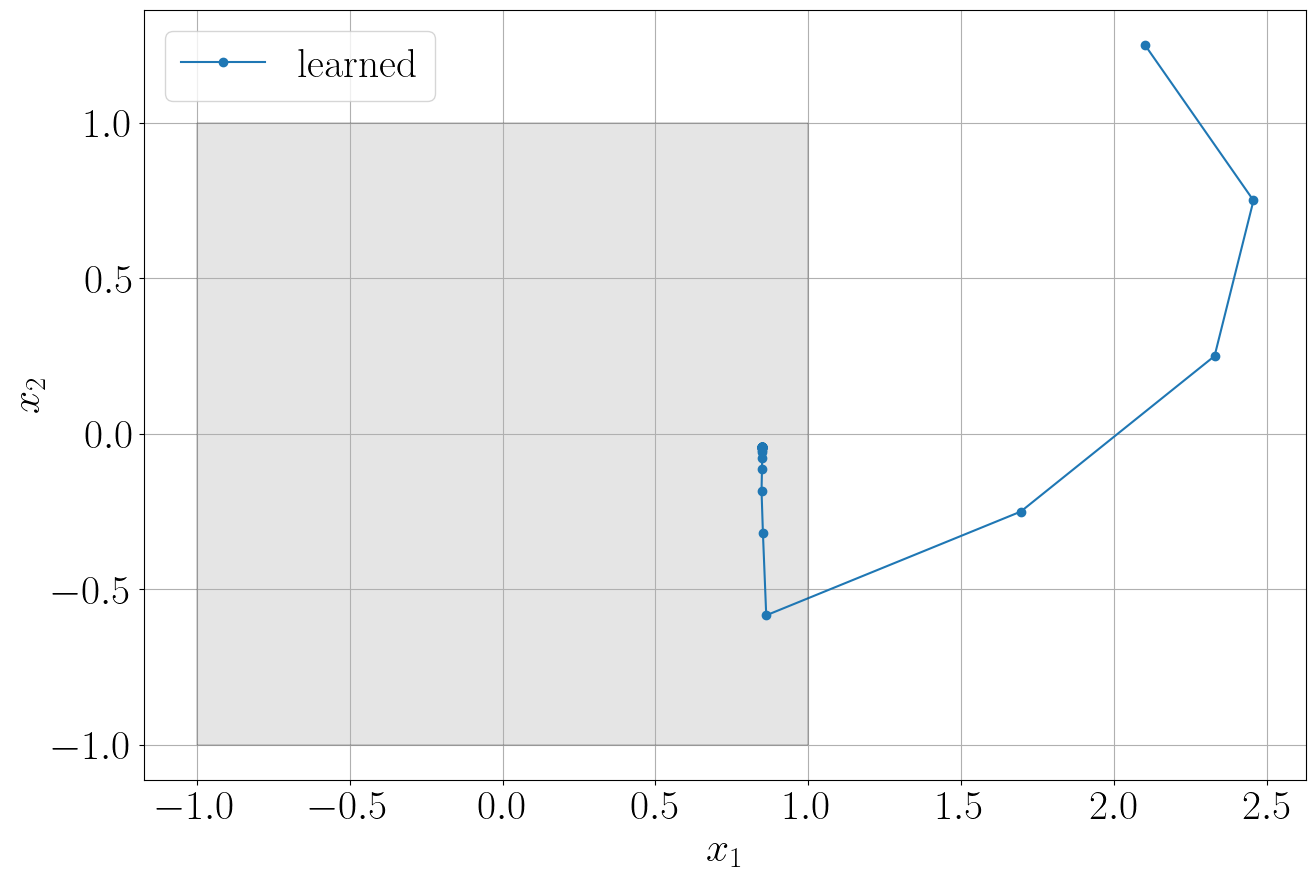

In [16]:
x_sim, u_sim= sim.simulate_discrete(x0, lin_sys, controller_object=learned_controller_max, Nsteps=N_steps)
plt.plot(x_sim[:,0], x_sim[:,1], '-o',  label = 'learned')
XConstraints.plot(facecolor='grey', alpha=0.2, edgecolor='k', linewidth=0.2)
plt.legend()
plt.grid()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

### Multiple ICs Simulation

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/home/robin/.pyenv/versions/apcbf_test_2/lib/python3.8/site-packages/pytope/polytope.py:381: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  h_patch.append(ax.add_patch(Polygon(V_sorted, **temp_dict)))
/home/robin/.pyenv/versions/apcbf_test_2/lib/python3.8/site-packages/pytope/polytope.py:386: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  h_patch.append(ax.add_patch(Polygon(V_sorted, **temp_dict)))


Text(0, 0.5, '$x_2$')

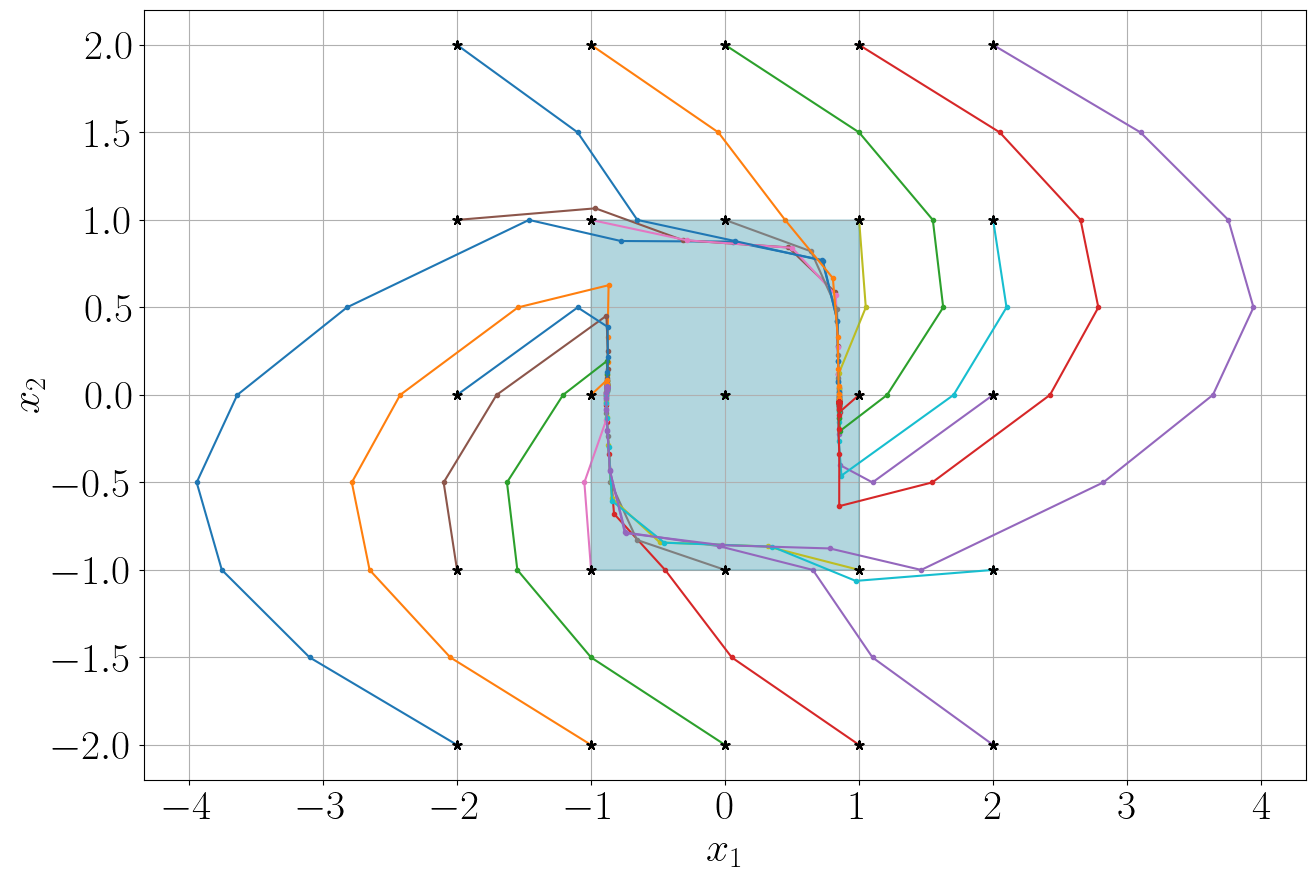

In [17]:
from tqdm.notebook import tqdm
#%matplotlib widget
n_points = 5 # per axis
x1 = np.linspace(-2,2,n_points)
x2 = np.linspace(-2,2,n_points)
x1,x2 = np.meshgrid(x1,x2)
hpb_learned_traj = np.zeros((n_points*n_points, len(x1), len(x2)))
#hpb_true = np.zeros((len(x1), len(x2)))
numb_exceptions = 0
hbp_collection = []
xis_collection = []
hpb_true_collection = []

total_times = []
# load optimal safety filter
slack_opt = SlackOpt(lin_sys=lin_sys, X = params_dict['X'], U = params_dict['U'], delta_i = delta_i, alpha_f = params_dict['alpha_f'] , P_f = params_dict['Pf'], gamma_x = params_dict['gamma_x'])
gsi, gsi_N, opt_value = slack_opt.solve(x0)

for j in tqdm(range(len(x1))):
    for k in tqdm(range(len(x2)), leave = False):
        x_sim_ic, u_sim_ic = sim.simulate_discrete(np.array([x1[j,k], x2[j,k]]), lin_sys, controller_object=learned_controller_max, Nsteps=N_steps)
        
        xis_collection.append(learned_controller_max.xi_list)
        learned_controller_max.xi_list = []
        hpb_true_traj = []      
        hpb_learned_traj = []
        
        for idx in range(len(x_sim_ic)):
            with torch.no_grad():
                hpb_learned_traj.append(model(torch.from_numpy(x_sim_ic[idx,:]).float()).numpy())
            _, _, h_temp = slack_opt.solve(x_sim_ic[idx,:])
            hpb_true_traj.append(h_temp)
        
        hbp_collection.append(hpb_learned_traj)
        hpb_true_collection.append(hpb_true_traj)
        plt.plot(x_sim_ic[:,0], x_sim_ic[:,1], '-o', markersize=3,  label = 'safe')
        plt.scatter(x1[j,k], x2[j,k],marker=(5, 2), color='k', zorder=100)

plt.grid()
XConstraints.plot(facecolor='grey', alpha=0.3, edgecolor='k', color = constraint_color , linewidth=0.2)                  
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
#plt.savefig(f'plots/pdf/linear_approach_1_multtraj_learned_sf_{LOG_NAME}_multiple_ic_{n_points}pts_latex.pdf', bbox_inches = 'tight')

#### Plot CBF values along trajectories

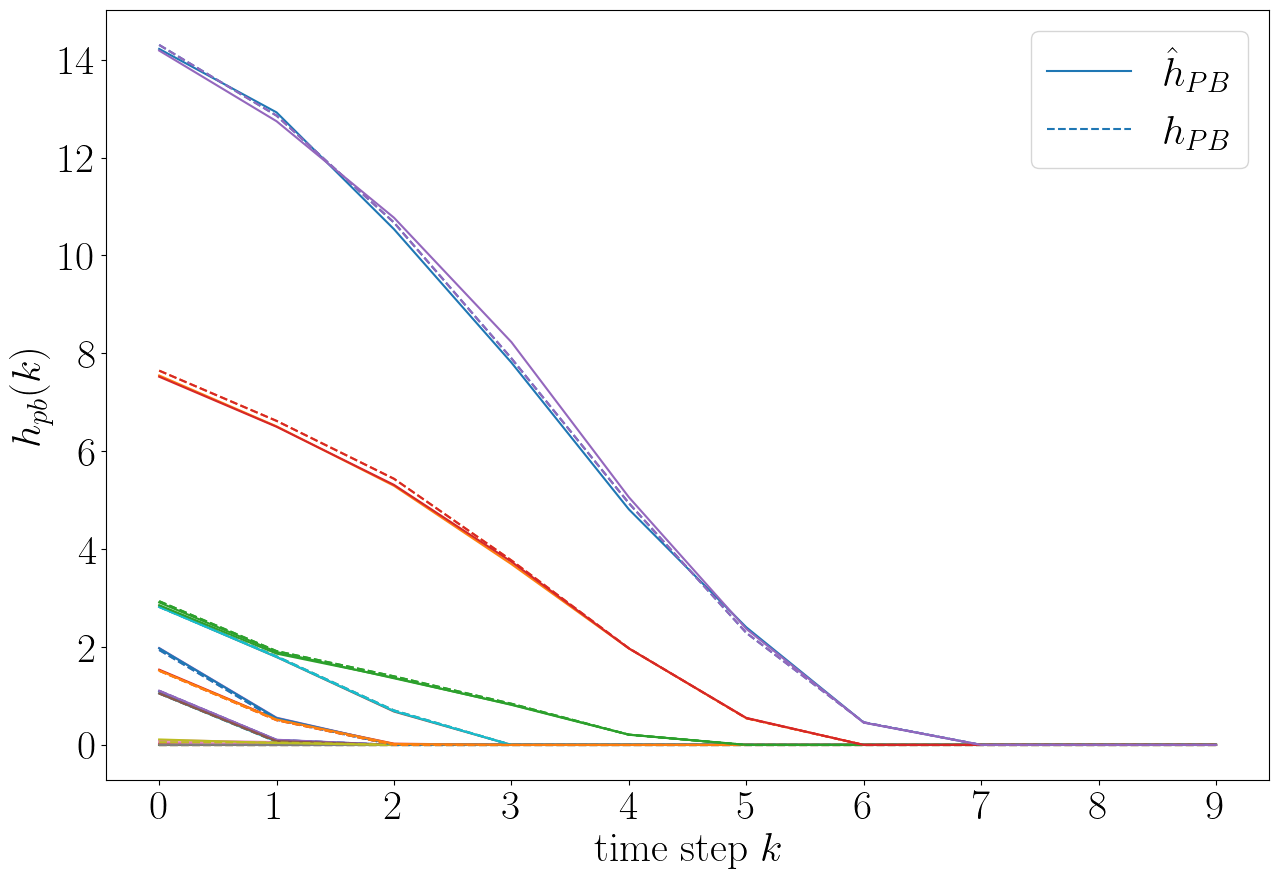

In [18]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
window = 10
max_learned_values = []
for l in range(len(hbp_collection)):
    max_learned_values.append(max(np.array(hbp_collection[l][18:])[0]))
    #with np.printoptions(precision=8, threshold=5):
        #print(f'learned : {max(np.array(hbp_collection[l][9:])[0])}')
        #print(f'true : {max(np.array(hpb_true_collection[l][9:]))}')
    p = plt.plot(hbp_collection[l][:window], label='$\hat{h}_{PB}$' if l == 0 else '')
    plt.plot(hpb_true_collection[l][:window],'--',label='${h}_{PB}$' if l == 0 else '', color = p[-1].get_color())
    
#plt.title('Learned $h_bp$ trajectories for different initial conditions');
plt.xlabel('time step $k$')
plt.ylabel('${h}_{pb}(k)$')
plt.legend()
#plt.savefig(f'plots/pdf/linear_approach_1_traj_learned_sf_{LOG_NAME}_hbpvstrue_{n_points}pts_latex.pdf', bbox_inches = 'tight')

# Class $\mathcal{K}_{\infty}$ function for the decrease rate \$\Delta h_{\mathrm{PB}}$

Set $\Delta h_{\mathrm{PB}} = \alpha(x(k))$ where $\alpha$ is a class $\mathcal{K}_{\infty}$ function.


\begin{equation} \min_{u, \xi} || u - u_p|| + \alpha_\xi\xi  \\ \text{subj.} \hat{h}_{\mathrm{PB}}(x^+) - \hat{h}_{\mathrm{PB}}(x) \leq -\Delta h_{\mathrm{PB}}+ \delta_{tol} + \xi\\ \end{equation}

Implementation in code : see script file `apcbf/approximate_pcbf_linear` 

In [19]:
learned_controller_kinf = APCBFSafetyFilterKINFDEC(model=model, m_type=model_type_name,
                                                   lin_sys= lin_sys, performance_controller = bad_ctrl, params_dict=params_dict, verbose = False)
u_test = learned_controller_kinf.input(np.array([0.3,.2]).reshape(2,1))
u_test

array([0.36697079])

### Simulation test

Text(0, 0.5, '$x_2$')

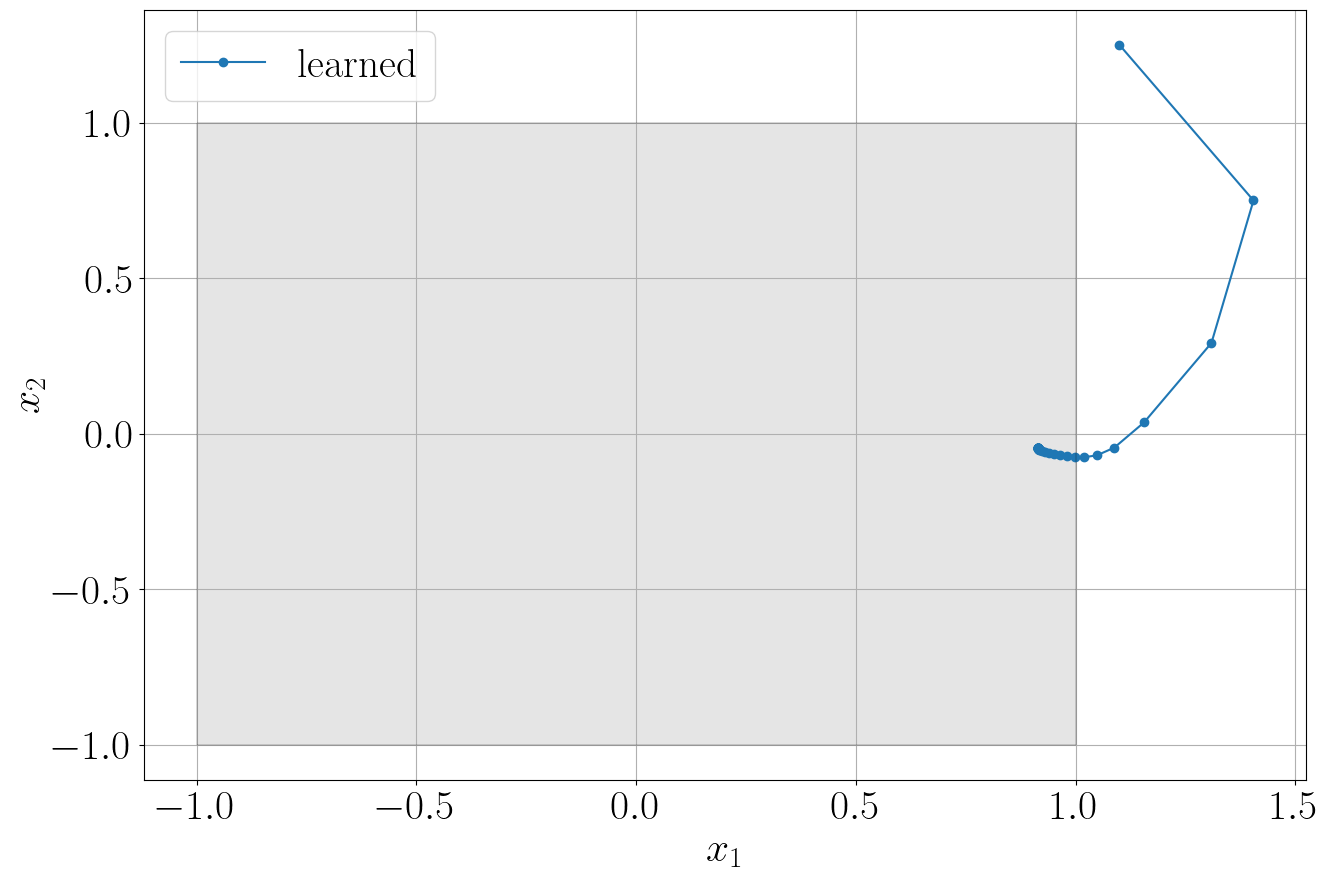

In [20]:
x0 = np.array([1.1,1.25])
x_sim, u_sim= sim.simulate_discrete(x0, lin_sys, controller_object=learned_controller_kinf, Nsteps=N_steps)
plt.plot(x_sim[:,0], x_sim[:,1], '-o',  label = 'learned')
XConstraints.plot(facecolor='grey', alpha=0.2, edgecolor='k', linewidth=0.2)
plt.legend()
plt.grid()
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

#### Multiple ICs Simulation

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0, 0.5, '$x_2$')

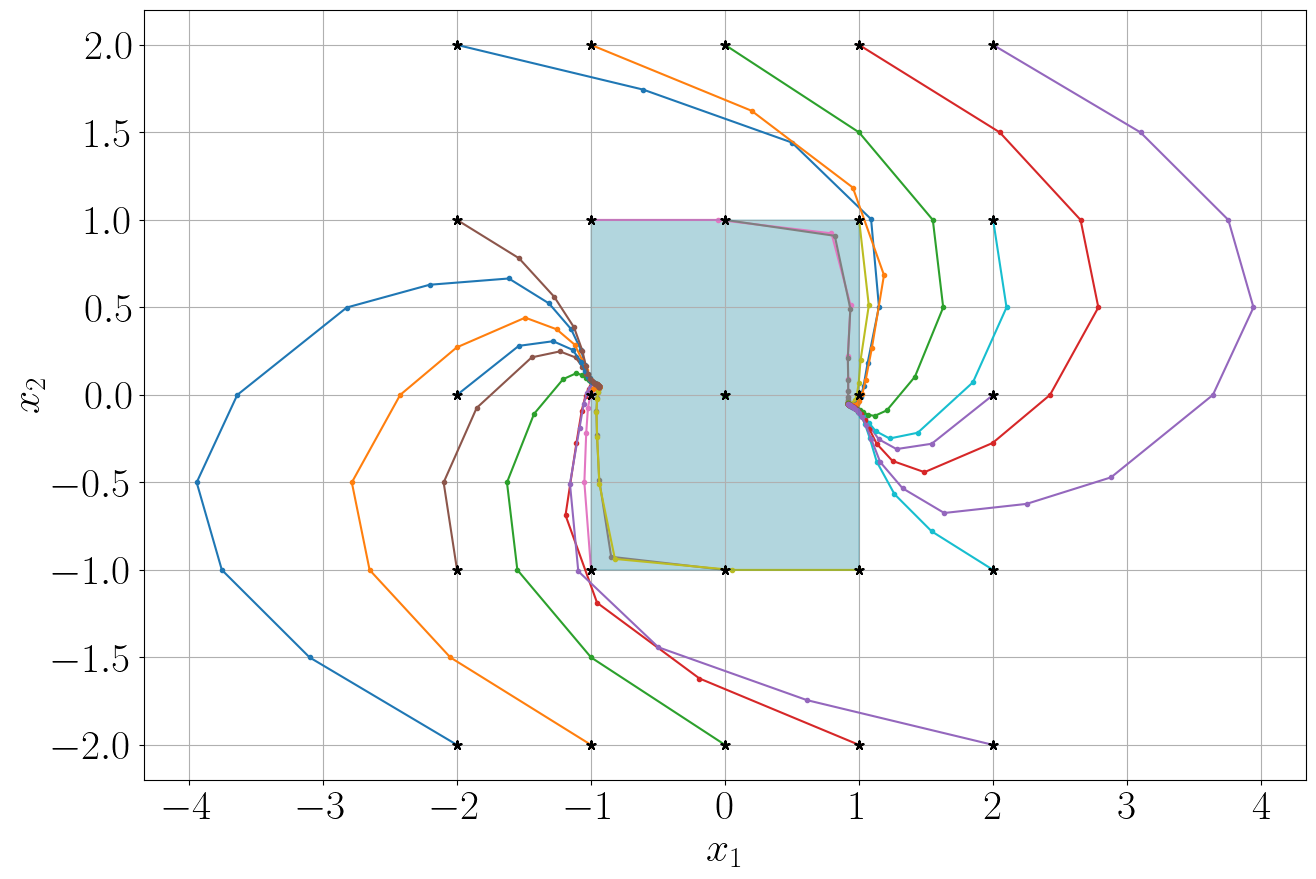

In [21]:
N_steps = 20
from tqdm.notebook import tqdm
#%matplotlib widget
n_points = 5 # per axis
x1 = np.linspace(-2,2,n_points)
x2 = np.linspace(-2,2,n_points)
x1,x2 = np.meshgrid(x1,x2)
hpb_learned_traj = np.zeros((n_points*n_points, len(x1), len(x2)))
#hpb_true = np.zeros((len(x1), len(x2)))
numb_exceptions = 0
hbp_collection = []
xis_collection = []

hpb_true_collection = []

total_times = []
# load optimal safety filter
slack_opt = SlackOpt(lin_sys=lin_sys, X = params_dict["X"], U = params_dict["U"], delta_i = delta_i, alpha_f = params_dict['alpha_f'] , P_f = params_dict['Pf'], gamma_x = params_dict['gamma_x'])
gsi, gsi_N, opt_value = slack_opt.solve(x0)

for j in tqdm(range(len(x1))):
    for k in tqdm(range(len(x2)), leave = False):
        x_sim_ic, u_sim_ic = sim.simulate_discrete(np.array([x1[j,k], x2[j,k]]), lin_sys, controller_object=learned_controller_kinf, Nsteps=N_steps)
        
        xis_collection.append(learned_controller_kinf.xi_list)
        learned_controller_kinf.xi_list = []
        
        hpb_learned_traj = []
        hpb_true_traj = []
        
        for idx in range(len(x_sim_ic)):
            with torch.no_grad():
                hpb_learned_traj.append(model(torch.from_numpy(x_sim_ic[idx,:]).float()).numpy())
            _, _, h_temp = slack_opt.solve(x_sim_ic[idx,:])
            hpb_true_traj.append(h_temp)
        
        hbp_collection.append(hpb_learned_traj)
        hpb_true_collection.append(hpb_true_traj)
        plt.plot(x_sim_ic[:,0], x_sim_ic[:,1], '-o', markersize=3,  label = 'safe')
        plt.scatter(x1[j,k], x2[j,k],marker=(5, 2), color='k', zorder=100)

plt.grid()
XConstraints.plot(facecolor='grey', alpha=0.3, edgecolor='k', color = constraint_color , linewidth=0.2)                  
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
#plt.savefig(f'plots/pdf/linear_approach_2_multtraj_learned_sf_{LOG_NAME}_multiple_ic_{n_points}pts_latex.pdf', bbox_inches = 'tight')

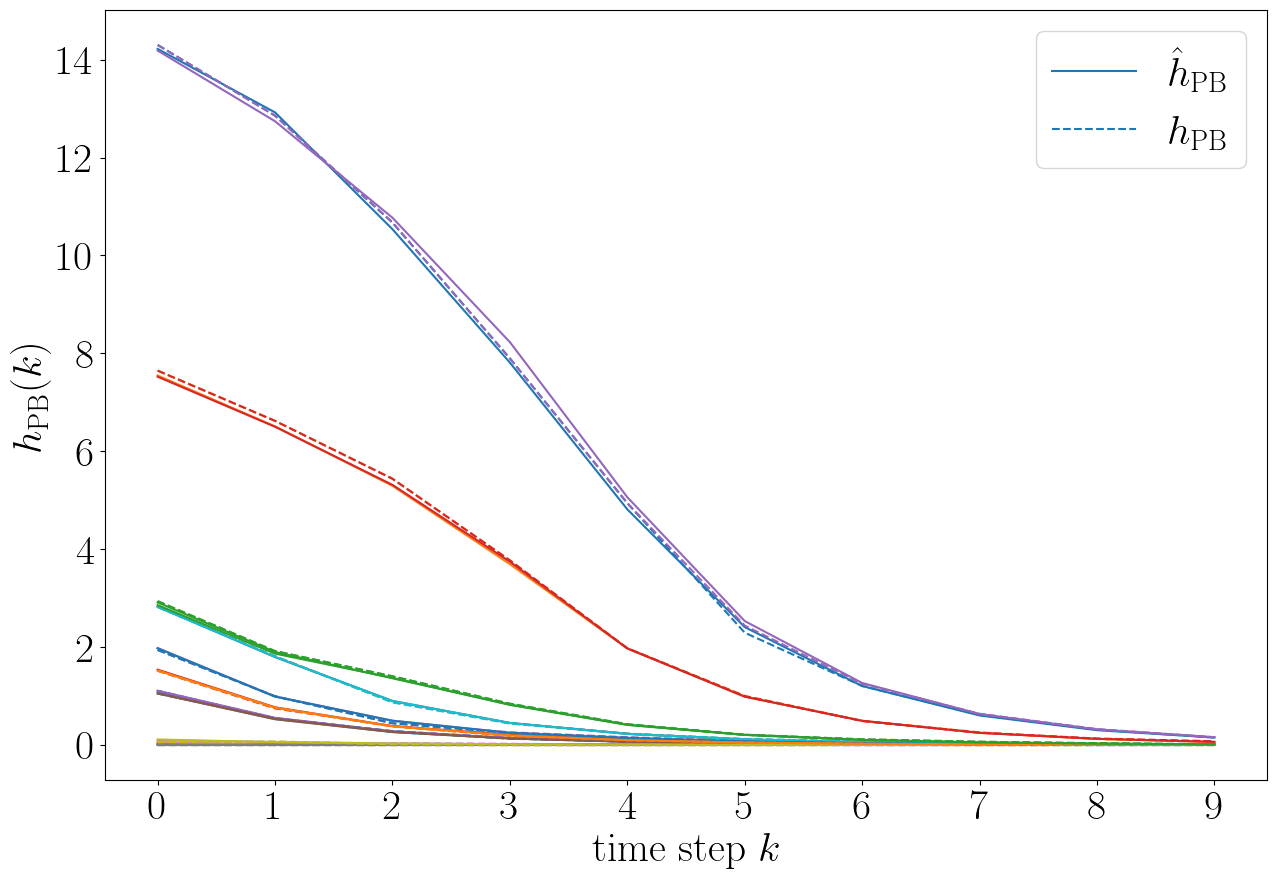

In [22]:
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
window = 10
max_learned_values = []
for l in range(len(hbp_collection)):
    max_learned_values.append(max(np.array(hbp_collection[l][14:])[0]))
#     with np.printoptions(precision=8, threshold=5):
#         print(f'learned : {max(np.array(hbp_collection[l][14:])[0])}')
#         print(f'true : {max(np.array(hpb_true_collection[l][14:]))}')
    p = plt.plot(hbp_collection[l][:window], label='$\hat{h}_{\mathrm{PB}}$' if l == 0 else '')
    plt.plot(hpb_true_collection[l][:window],'--',label='${h}_{\mathrm{PB}}$' if l == 0 else '', color = p[-1].get_color())

#plt.title('Learned $h_bp$ trajectories for different initial conditions');
plt.xlabel('time step $k$')
plt.ylabel('${h}_{\mathrm{PB}}(k)$')
plt.legend()
#plt.savefig(f'plots/pdf/linear_approach_2_traj_learned_sf_{LOG_NAME}_hbp_{n_points}pts_latex.pdf', bbox_inches = 'tight')